## getting started
`wavesolve` is a lightweight package to solve for the eigenmodes of waveguides. It employs the finite-element method (specifically, Galerkin's method - read more <a href = "finite_element_method_notes.pdf"> here</a>.) The general workflow for `wavesolve` is the following:

1. Specify the waveguide boundaries (e.g. the outer cladding radius and the core radius for step-index optical fibers. 
2. Create a mesh, that is contained/divided by the boundaries you specified. `wavesolve` uses the `pygmsh` package to handle this.
3. Assign an index of refraction to each bounded area in the mesh.
4. Compute the corresponding finite-element matrix to this mesh structure.
5. Solve the eigenvector problem associated with this matrix, giving the guided modes.

Below, we walk through a few examples to get users familiar.

### optical fiber modes
In this section, we will numerically compute the guided modes of a circular, step-index optical fiber. These are the well-known "linearly polarized" (LP) modes. First, we must define our waveguide geometry and create a mesh to represent that geometry:

In [8]:
wavelength = 1.55 # um
rclad = 10 # um, because our wavelength is in um. this is the cladding radius
rcore = 5 # um. this is the core radius
res = 32 # this sets the number of line segments forming the core-cladding boundary. higher -> finer mesh
         # at the expense of slower calculation and more memory use.

from wavesolve import mesher

### easy way to make a fiber ###
fib = mesher.fiber_mesh(rclad,rcore,res)

Next, we assign index of refraction values to each region in the mesh, using a dictionary. `fiber_mesh` produces two regions, identified as `core` and `cladding`. After specifying which regions of the mesh have what refractive index, we can plot using `mesher.plot_mesh()`. This function plots all the triangles in the mesh, as well as the edge midpoints (which are used in quadratic-triangles finite-element analysis); each triangle is colored according to the refractive index.

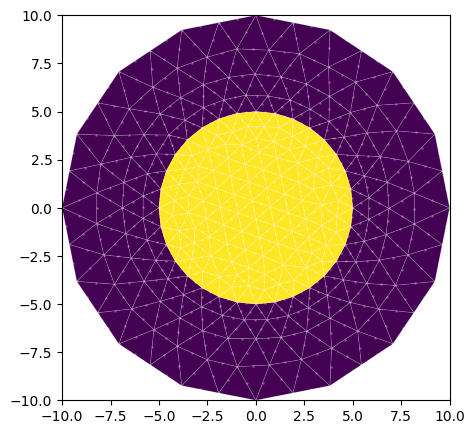

In [9]:
ncore = 1.4504
nclad = 1.444
IOR_dict = {'core': ncore,'cladding':nclad}
mesher.plot_mesh(fib,IOR_dict)

#### aside: a closer look at meshing
While `wavesolve` provides a relatively simple way to make meshes for optical fibers, there may be no pre-made function for a complex geometry you want to simulate. So, below, we build the optical fiber mesh explicitly, with `pygmsh`. Using the same principles, you can make arbitrary step-index waveguides.

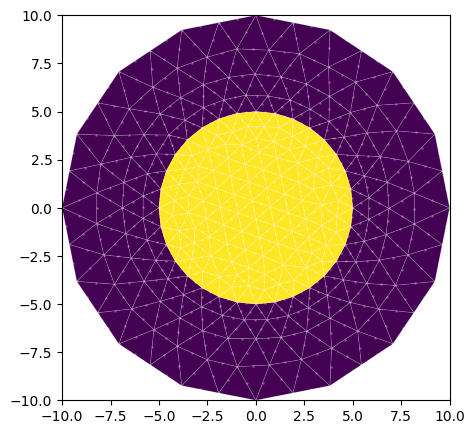

In [11]:
### hard (but more flexible way) to make a fiber ###
import pygmsh
from wavesolve.mesher import circ_points

with pygmsh.occ.Geometry() as geom:
    cladding_boundary = circ_points(rclad,int(res/2))   # specify cladding boundary, which 
                                                        # is just a list of points going in a circle
    cladding_base = geom.add_polygon(cladding_boundary) # convert boundary to polygon
    core = geom.add_polygon(circ_points(rcore,int(res)))# do the same for the core

    # because the core and cladding overlap, we do a boolean subtract to remove the overlapping part
    # this makes a new `cladding` polygon that looks like a ring
    cladding = geom.boolean_difference(cladding_base,core,delete_other = False) 

    # now add each meshed polygon (the circular core and the annular cladding) to the overall geometry,
    # assigning a nametag to each. these tags are used to assign a refractive index value later.
    geom.add_physical(cladding,"cladding")
    geom.add_physical(core,"core")

    fib2 = geom.generate_mesh(dim=2,order=2,algorithm=6) # algo 6 works well, read more in pygmsh documentation

    mesher.plot_mesh(fib2,IOR_dict)


#### solving
With our mesh and refractive indices defined, we can construct the corresponding matrix using `fe_solver.construct_AB()` and solve/plot eigenvectors with `fe_solver.solve()`.

effective index:  1.4479241545713193


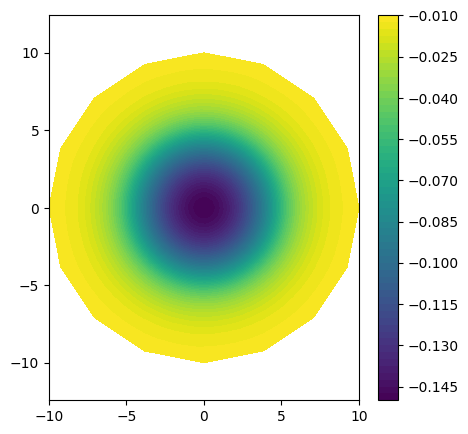

effective index:  1.4448744541102865


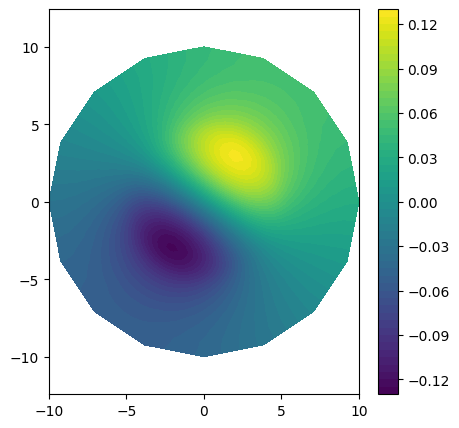

effective index:  1.4448744522063908


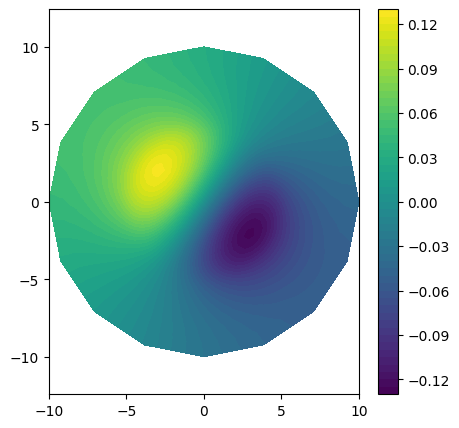

effective index:  1.442981730591464


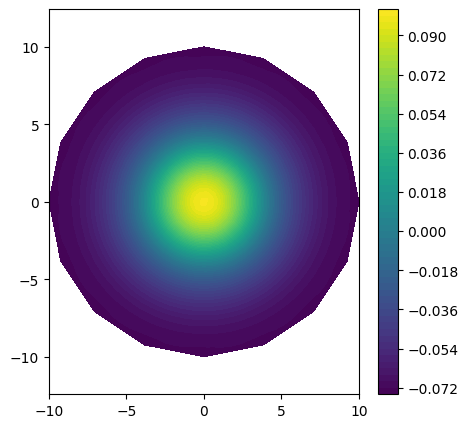

In [14]:
from wavesolve.fe_solver import construct_AB,solve,plot_eigenvector
import numpy as np

k = 2*np.pi/wavelength # wavenumber
A,B = construct_AB(fib,IOR_dict,k) # construct matrices for FE analysis
w,v,N = solve(A,B,fib,k,IOR_dict,plot=True) # returns eigenvalues, eigenvectors, and total number of modes

Note that the code returns four modes, ordered in descending eigenvalue; however the last is tagged as "spurious". FE mode solvers  will return so-called "cladding" modes that are unphysical. Whether a mode is physical or unphysical can be easily determined by looking at the corresponding eigenvalue, which can be converted to an effective index. As far as I am aware, this issue is a property of all FE solvers. The first 3 modes recovered are the usual LP01 and LP11 modes.

## A slightly harder example: 3-port photonic lantern entrance

The small end of a 3-port photonic lantern can have a triangle geometry, if the lantern is formed by fusing and tapering down a bundle of single-mode fibers. Below we use the `mesher.lantern_mesh_3PL()` function, which generates a mesh that matches the endface geometry observed in microscope images, taken of 3-port PLs at SCExAO/Subaru.

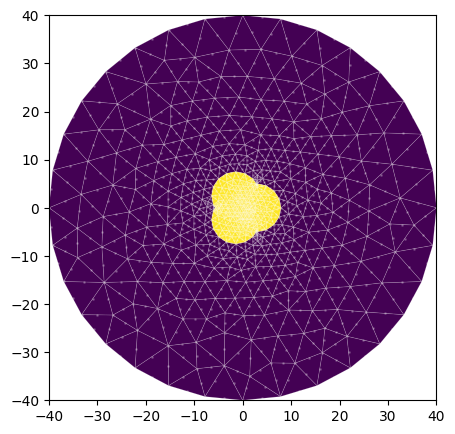

In [20]:
from wavesolve import mesher

r = 5 # the 3-port PL endface core geometry looks like three overlapping, slightly displaced circles.
      # r is the radius of each circle.
res = 16
PL = mesher.lantern_mesh_3PL(r,res)

# the two regions in the 3PL are called `cladding` and `jacket`. They are analogous to the core and cladding
# of a standard optical fiber. 
IOR_dict = {'cladding': 1.444,'jacket':1.444-5.5e-3}
mesher.plot_mesh(PL,IOR_dict)

Now solving ...

effective index:  1.442511424960973


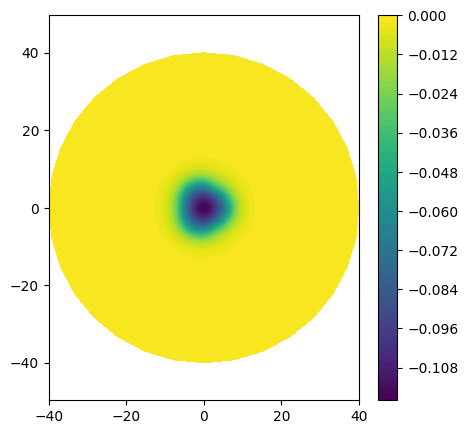

effective index:  1.440448450643226


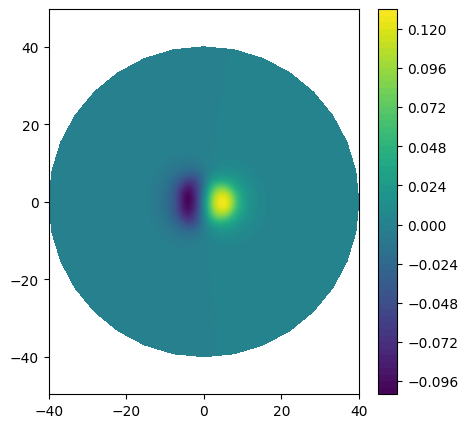

effective index:  1.4404478926591575


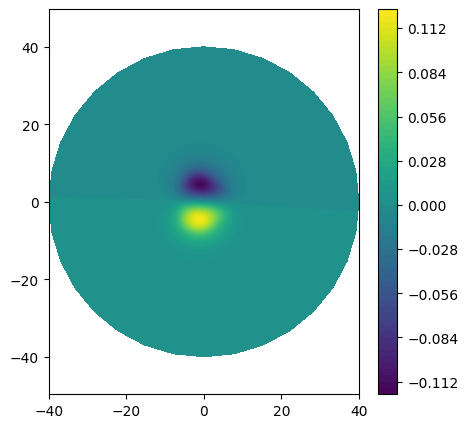

effective index:  1.4384921056718944


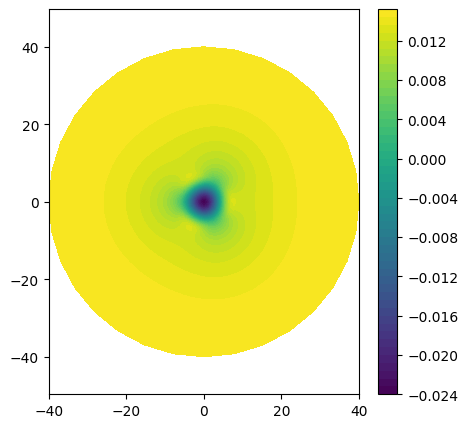

In [22]:
from wavesolve import fe_solver
import numpy as np

k = 2*np.pi/1.55
A,B = fe_solver.construct_AB(PL,IOR_dict,k)
w,v,N = fe_solver.solve(A,B,PL,k,IOR_dict,plot=True)

## A final note
At least on my machine, `scipy.linalg.eigh()` becomes unstable when matrices become larger than around 2000 by 2000. In these cases, it might be better to use sparse matrices. The usual `A,B` matrices can be converted into "compressed sparse row" (CSR) format and then solved using `fe_solver.solve_sparse`. Since this is a sparse method, you must specify the maximum number of eigenmodes for the code to return. 